In [5]:
%matplotlib inline
from numpy import linspace, log, exp
from numpy.random import normal
from scipy.stats import chisqprob
from lmfit import Model
import seaborn as sns
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1)

# The likelihood ratio test: Python implementation

For two models, one nested in the other (meaning that the nested model estimated parameters are a subset of the nesting model), the test statistic $D$ is (based on [this](http://www.stat.sc.edu/~habing/courses/703/GLRTExample.pdf)):

$$
\Lambda = \Big( \Big(\frac{\sum{(X_i - \hat{X_i}(\theta_1))^2}}{\sum{(X_i - \hat{X_i}(\theta_0))^2}}\Big)^{n/2} \Big) \\
D = -2 log \Lambda \\
lim_{n \to \infty} D \sim \chi^2_{df=\Delta}
$$

where $\Lambda$ is the likelihood ratio, $D$ is the statistic, $X_{i}$ are the data points, $\hat{X_i}(\theta)$ is the model prediction with parameters $\theta$, $\theta_i$ is the parameters estimation for model $i$, $n$ is the number of data points and $\Delta$ is the difference in number of parameters between the models.

The python implementation below compares between two `lmfit.ModelFit` objects. These are the results of fitting models to the same data set using the [`lmfit` package](lmfit.github.io/lmfit-py/). 

The function compares between model fit `m0` and `m1` and assumes that `m0` is nested in `m1`, meaning that the set of varying parameters of `m0` is a subset of the varying parameters of `m1`. The property `chisqr` of the `ModelFit` objects is the sum of the square of the residuals of the fit. `ndata` is the number of data points. `nvarys` is the number of varying parameters.

In [31]:
def lrtest(m0, m1, alfa=0.05):
    """Perform a likelihood ratio test on two nested models.
    
    Input:
    
    `m0` is nested in `m1`.
    `alfa` is the test significance level (default 5%).
    
    Output:
    
    prefer_m1 - a boolean, should we prefer `m1` over `m0`.
    pval - the test p-value
    D - the test statistic 
    ddf - the number of degrees of freedom
    """
    n0 = m0.ndata
    k0 = m0.nvarys
    chisqr0 = m0.chisqr
    assert chisqr0 > 0
    n1 = m1.ndata
    assert n0 == n1
    k1 = m1.nvarys
    chisqr1 = m1.chisqr
    assert chisqr1 > 0
    Lambda = (m1.chisqr / m0.chisqr)**(n0 / 2.)
    D = -2 * log( Lambda )
    assert D > 0
    ddf = k1 - k0
    assert ddf > 0
    pval = chisqprob(D, ddf)
    prefer_m1 = pval < alfa
    return prefer_m1, pval, D, ddf

## Test on a simple model

We test the function on data generated from the equation:

$$
y = b + e^{-a t} + N(0, \sigma^2)
$$

where $a$ and $b$ are the parameters, $t$ is the variable, and $N$ is the normal distribution.

We fit a nesting model `model_fit1` (the alternative hypothesis of the test). This model estimates both $a$ and $b$.
We also fit a nested model `model_fit0` (the nul hypothesis of the test) in which either $a$ or $b$ is fixed at an initial value.
We than plot both model fits, print the estimated parameters, the test statistic and the p-value of the test.

In [34]:
# test lrt
def lrtest_test(a, b, a_init, b_init, a_vary, b_vary, sig=0.1, N=100, alfa=0.05):
    assert a_vary or b_vary
    assert not(a_vary and b_vary)
       
    t = linspace(0,1,N)
    f = lambda t,a,b: b + exp(-a*t)
    data = f(t,a,b) + normal(0, sig, N)
    fig, ax = subplots(1,2,sharex=True,sharey=True,figsize=(15,5))
    print "real:", a,b
    model = Model(f)
    params = model.make_params(a=a_init, b=b_init)

    two_var_fit = model.fit(data, t=t, params=params)
    two_var_fit.plot_fit(ax=ax[1])
    ax[1].set_title("Two variables")
    #model_fit1.plot_residuals(ax[1])
    print "Two variables:",two_var_fit.best_values

    params['a'].set(vary=a_vary)
    params['b'].set(vary=b_vary)
    one_var_fit = model.fit(data, t=t, params=params)
    one_var_fit.plot_fit(ax=ax[0])
    #model_fit0.plot_residuals(ax[0])
    ax[0].set_title("One variable")
    print "One variable:",one_var_fit.best_values

    prefer_m1,pval,D,ddf = lrtest(one_var_fit, two_var_fit, alfa)
    print "pval=%.2g, D=%.2g, ddf=%d" % (pval, D, ddf)
    print "Decision with significance level %.2g:" % alfa,
    if prefer_m1:
        print "Two variable model"
    else:
        print "One variable model"
    return t,data

real: 1 1
Two variables: {'a': 0.86775531514445625, 'b': 0.97560666838937937}
One variable: {'a': 1, 'b': 1.0118956348766281}
pval=0.19, D=1.7, ddf=1
Decision with significance level 0.05: One variable model


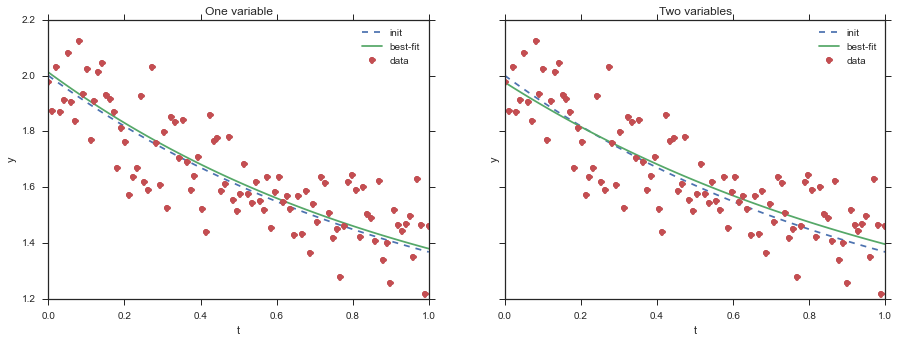

In [35]:
lrtest_test(1,1,1,1,False,True);

real: 1 1
Two variables: {'a': 0.88198851749015894, 'b': 0.95415310004056564}
One variable: {'a': 1.0278836663608819, 'b': 1}
pval=0.042, D=4.1, ddf=1
Decision with significance level 0.05: Two variable model


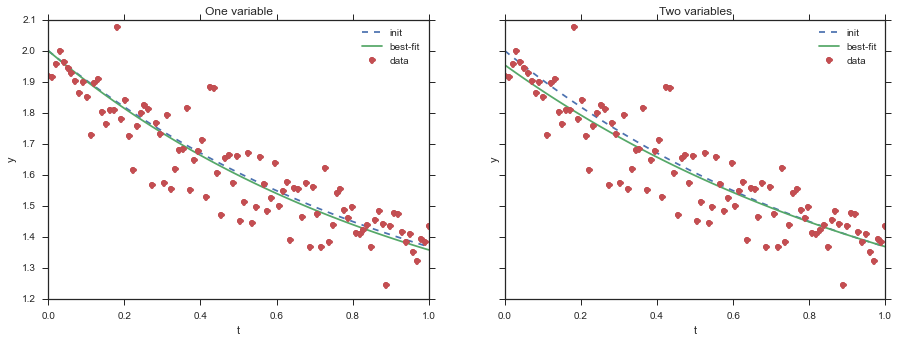

In [36]:
lrtest_test(1,1,1,1,True,False);

real: 1 1
Two variables: {'a': 1.0842648241878579, 'b': 1.0287763184769507}
One variable: {'a': -0.5729794466048922, 'b': 0}
pval=1.2e-72, D=3.2e+02, ddf=1
Decision with significance level 0.05: Two variable model


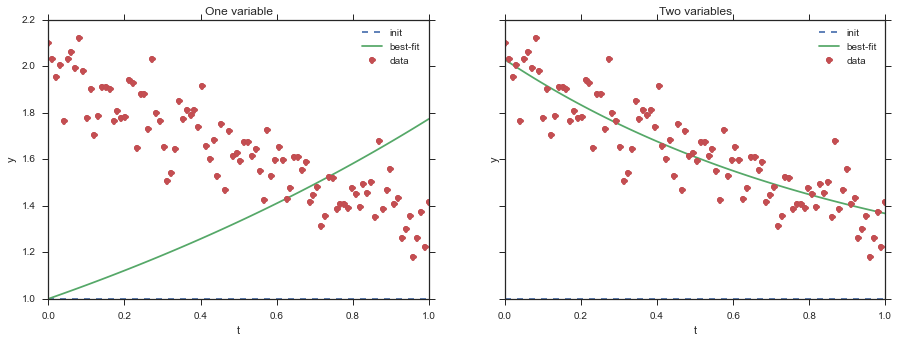

In [37]:
lrtest_test(1,1,0,0,True,False);

real: 1 1
Two variables: {'a': 0.9452008165850978, 'b': 0.98442967528266856}
One variable: {'a': 0, 'b': 0.63175416158525943}
pval=5.3e-35, D=1.5e+02, ddf=1
Decision with significance level 0.05: Two variable model


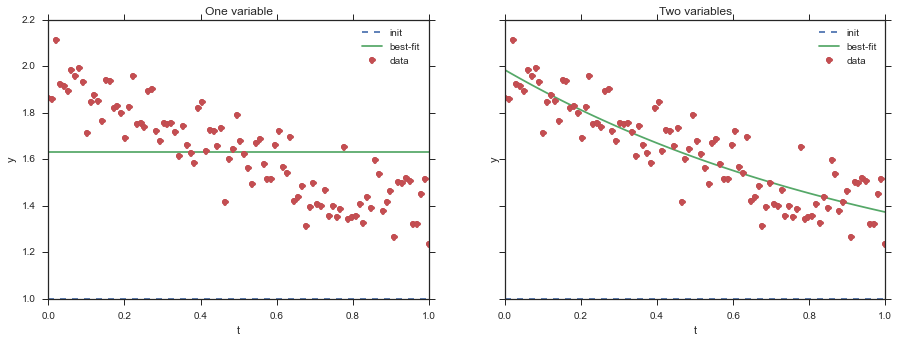

In [38]:
lrtest_test(1,1,0,0,False,True);

real: 1 1
Two variables: {'a': 0.98872695387898135, 'b': 0.98522534209144352}
One variable: {'a': 0, 'b': 0.62084932431698936}
pval=7.3e-35, D=1.5e+02, ddf=1
Decision with significance level 0.05: Two variable model


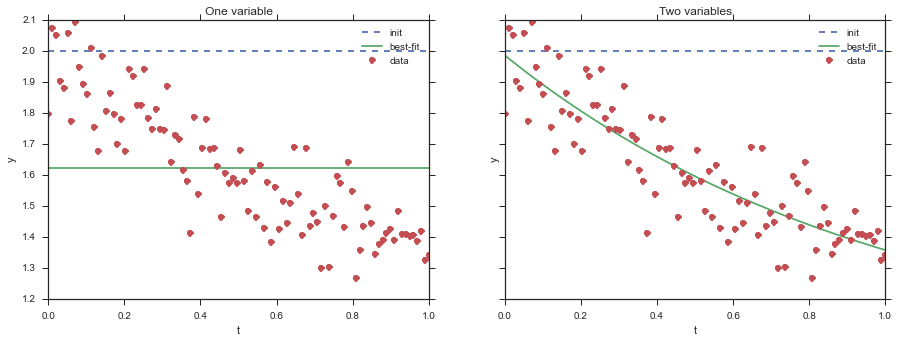

In [39]:
lrtest_test(1,1,0,1,False,True);

real: 1 1
Two variables: {'a': 1.0224399232088139, 'b': 0.99340603684830542}
One variable: {'a': 1.0446412443876858, 'b': 1}
pval=0.8, D=0.065, ddf=1
Decision with significance level 0.05: One variable model


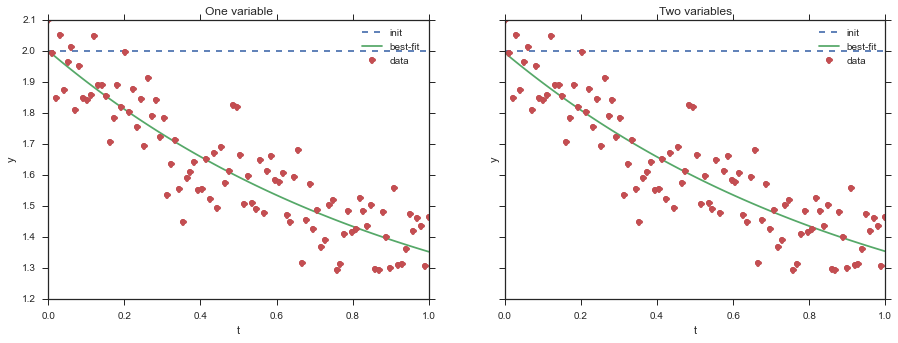

In [40]:
lrtest_test(1,1,0,1,True,False);

real: 1 1
Two variables: {'a': 0.87089207465018115, 'b': 0.96616302997657855}
One variable: {'a': -0.58724547087449808, 'b': 0}
pval=5e-74, D=3.3e+02, ddf=1
Decision with significance level 0.05: Two variable model


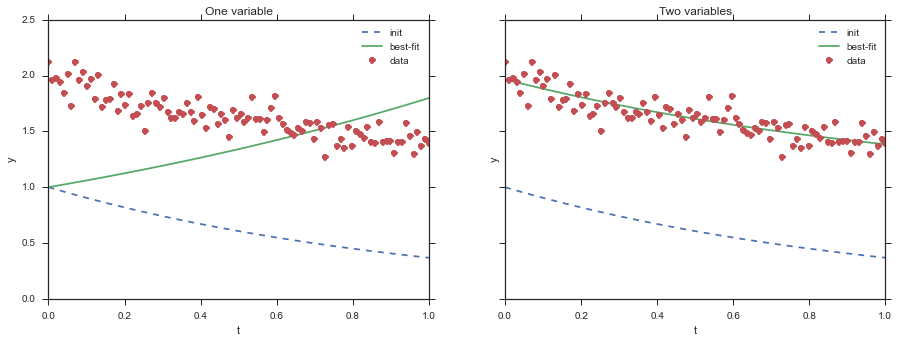

In [41]:
lrtest_test(1,1,1,0,True,False);

real: 1 1
Two variables: {'a': 1.0285746095656456, 'b': 1.0174174562149918}
One variable: {'a': 1, 'b': 1.0099552907882328}
pval=0.77, D=0.086, ddf=1
Decision with significance level 0.05: One variable model


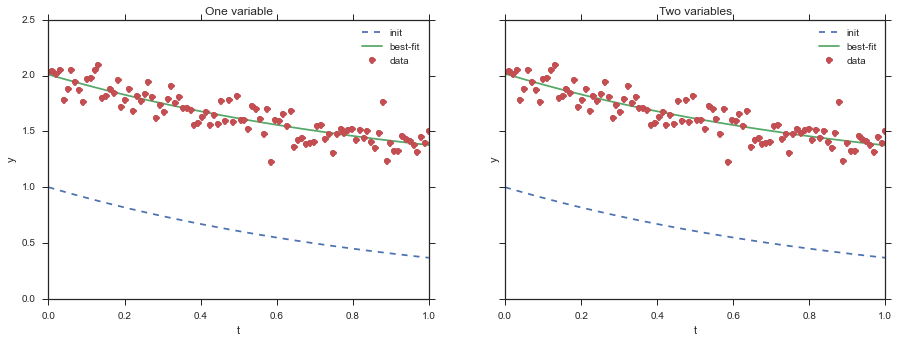

In [42]:
lrtest_test(1,1,1,0,False,True);

real: 1 1
Two variables: {'a': 1.0888695144064144, 'b': 1.0317987702059201}
One variable: {'a': 2, 'b': 1.2079536785181528}
pval=3.3e-07, D=26, ddf=1
Decision with significance level 0.05: Two variable model


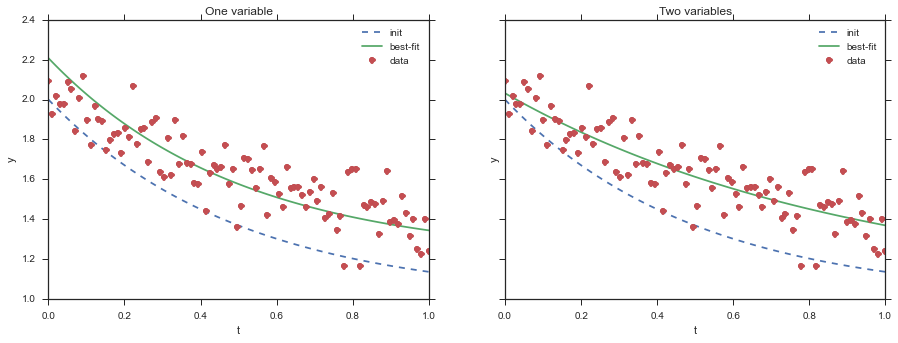

In [43]:
lrtest_test(1,1,2,1,False,True);

## Compare with R

Here we compare the Python implementation with the R implementation - `lmtest::lrtest`. The data is generated from a quadratic polynomial:

$$
y = at^2 + bt + c + N(0,\sigma^2)
$$

and we fit two models - the nested model is a linear function and the nesting model is a quadratic polynomial.

### Note

In order to get this to work you will need to make sure the `lmtest` package is installed (don't install via RStudio - use regular command line R) and that the `R_HOME` and `R_USER` environment variable are set to where R is running from the command line and where the packages are installed to when running from the command line.

In [44]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [45]:
!echo %R_HOME%
!echo %R_USER%

C:/Progra~1/R/R-3.0.3
C:\Users\yoavram\R


In [47]:
for _ in range(10):
    N = 100
    sig = 0.1
    a,b,c = 0.1,1,1
    t = linspace(0,1,N)
    f = lambda t,a,b,c: c + b*t + a*t**2
    data = f(t,a,b,c) + normal(0, sig, N)
    model = Model(f)
    params = model.make_params(a=0, b=0, c=0)

    model_fit1 = model.fit(data, t=t, params=params)

    params['a'].set(vary=False)
    model_fit0 = model.fit(data, t=t, params=params)

    prefer_m1,pval,D,ddf = lrtest(model_fit0, model_fit1)
    print "py",
    print pval

    print "R ",
    %Rpush t data
    %R library(lmtest)
    %R lm1=lm(data~t)
    %R lm2=lm(data~t+I(t^2))
    %R pvalue = lrtest(lm2,lm1)[2,5]
    %Rpull pvalue
    print pvalue[0]

py 0.0179882275173
R  0.0179882275173
py 0.537531566876
R  0.537531566876
py 0.269018479047
R  0.269018479047
py 0.495471455839
R  0.495471455839
py 0.546745762151
R  0.546745762151
py 0.662389288421
R  0.662389288421
py 0.534273698101
R  0.534273698101
py 0.0422040728343
R  0.0422040728343
py 0.633756809221
R  0.633756809221
py 0.203276605564
R  0.203276605564


## License

This notebook was written by [Yoav Ram](http://www.yoavram.com) and [Uri Obolski](https://sites.google.com/site/hadanylab/people/uri-obolski). 
The notebook was written to facilitate the discussion on [lmfit mailing-list](https://groups.google.com/forum/?fromgroups#!topic/lmfit-py/NuQsmZ6D4vY).
The latest version can be found at [ipython.yoavram.com](http://nbviewer.ipython.org/github/yoavram/ipython-notebooks/blob/master/likelihood%20ratio%20test.ipynb). 

The code is released with a CC-BY-SA 3.0 license.